# Imports/Setup

In [1]:
import os
import sys
import urllib
from collections import defaultdict

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord, EarthLocation, get_sun
from astropy.time import Time
from astropy.io import fits

import astroquery

from importlib import reload

%matplotlib inline
from matplotlib import style, pyplot as plt

In [2]:
working_dir = os.path.abspath('..')

%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $working_dir

/Users/erik/projects/saga/saga
running build
running build_py
/Users/erik/projects/saga/erik


In [3]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

from SAGA.database.external import SdssQuery, DesQuery, download_catalogs_for_hosts
import SAGA as saga

Adding /Users/erik/projects/saga/saga/build/lib to the python path


# Get Data

In [4]:
# get host list
saga_database = saga.Database(os.path.join(os.environ['HOME'],'Dropbox/SAGA/'))
saga_host_catalog = saga.HostCatalog(saga_database)

In [5]:
hosts_to_load = 'has_des'
des_hosts = saga_host_catalog.load(hosts_to_load)
des_hosts['ID_STR'] = saga_host_catalog.resolve_id(hosts_to_load, 'string')

failed = download_catalogs_for_hosts(des_hosts, DesQuery, saga_database.des_file_path_pattern, overwrite=False, host_id_label='ID_STR')

print('# failed =', np.count_nonzero(failed))

[07/17 17:50:17] Getting catalog for host pgc1952 ...
[07/17 17:50:17] Getting catalog for host pgc2052 ...
[07/17 17:50:17] Getting catalog for host pgc2778 ...
[07/17 17:50:17] Getting catalog for host pgc3089 ...
[07/17 17:50:17] Getting catalog for host pgc5619 ...
[07/17 17:50:17] Getting catalog for host nsa130133 ...
[07/17 17:50:17] Getting catalog for host nsa130625 ...
[07/17 17:50:17] Getting catalog for host pgc9057 ...
[07/17 17:50:17] Getting catalog for host pgc9747 ...
[07/17 17:50:17] Getting catalog for host nsa132278 ...
[07/17 17:50:17] Getting catalog for host nsa132339 ...
[07/17 17:50:17] Getting catalog for host pgc10330 ...
[07/17 17:50:17] Getting catalog for host pgc10965 ...
[07/17 17:50:17] Getting catalog for host pgc11559 ...
[07/17 17:50:28] Getting catalog for host pgc11819 ...
[07/17 17:50:28] Getting catalog for host pgc12007 ...
[07/17 17:50:28] Getting catalog for host pgc12431 ...
[07/17 17:50:28] Getting catalog for host nsa133355 ...
[07/17 17:50

In [6]:
hosts_to_load = 'flag0'
flag0_hosts = saga_host_catalog.load(hosts_to_load)
flag0_hosts['ID_STR'] = saga_host_catalog.resolve_id(hosts_to_load, 'string')

In [10]:
nsahost = flag0_hosts[flag0_hosts['NSAID']==145398][0]
#path = '/home/yymao/Downloads/test.fits.gz'
qry = SdssQuery(nsahost['RA'], nsahost['Dec'], context='DR14', default_use_sciserver=False)
qry.download_as_file(saga_database.sdss_file_path_pattern.format('nsa' + str(nsahost['NSAID'])), overwrite=False)

In [11]:
nsahost = flag0_hosts[flag0_hosts['NSAID']==145398][0]
deshost = des_hosts[des_hosts['PGC'] == 2052][0]

Manually went to IRSA to download all of the USNO-B1, UCAC, URAT survets

In [106]:
from astroquery.gaia import Gaia

In [ ]:
fn = 'external_catalogs/astrometric/nsa145398_gaia.ecsv'
if not os.path.isfile(fn):
    nsa_gaiajob = Gaia.cone_search_async(nsahost['coord'], radius=1*u.deg, background=True)
    nsa_gaia = nsa_gaiajob.get_data()
    nsa_gaia.write(fn, format='ascii.ecsv')
else:
    nsa_gaia = Table.read(fn)
len(nsa_gaia)

In [ ]:
fn = 'external_catalogs/astrometric/pgc2052_gaia.ecsv'
if not os.path.isfile(fn):
    des_gaiajob = Gaia.cone_search_async(deshost['coord'], radius=1*u.deg, background=True)
    des_gaia = des_gaiajob.get_data()
    des_gaia.write(fn, format='ascii.ecsv')
else:
    des_gaia = Table.read(fn)
len(des_gaia)

# Compare Catalogs

In [107]:
mag_field_names = {}
mag_field_names['desdr1'] = 'r_mag'
mag_field_names['2mass'] = 'j_m'
mag_field_names['ucac5'] = 'rmag'
mag_field_names['usno_b1'] = 'r1_mag'
mag_field_names['sdss'] = 'r'
mag_field_names['urat'] = 'jmag'
mag_field_names['gaia'] = 'phot_g_mean_mag'

We start with an SDSS/NSA host for testing purposes.  There's no need for independent guide stars because SDSS's "bright chip" gives astrometric accuracy even for fairly bright stars.  But it's a good check to see how well the astrometric catalogs work, for comparison with the DES case.

## SDSS Host (NSA 632028/NGC 5701)

In [108]:
nsahost

<Row index=0 masked=True>
SAGA_name NSAID     RA     Dec    PGC  NSA1ID  NGC   UGC   vhelio distance    r       i       z       I       K     K_err   flag  K_abs    r_abs      b    dist_to_group brightest_K_nearby SDSS_FRACGOOD  RA_sub Dec_sub othername vhelio_sub vhelio_err distance_sub dist_2MASS_NSA    u      u_err      A_u      M_u       g       g_err      A_g      M_g    r_sub     r_err      A_r     M_r     i_sub     i_err       A_i      M_i     z_sub     z_err       A_z      M_z       J     J_err    A_J      M_J       H     H_err    A_H      M_H     K_sub  K_err_sub    A_K      M_K    stellar_mass sersic_n MK_compiled des_dr1 decals_dr5 decals_dr6      coord        ID_STR 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                deg,deg              
  str11   int64  float64 float64 int64 int64  int64 int64 float64 float64  float64 float64 float64 float64 float64 float64 int64 float64  float64  float64    float64         float64          float64    float64 float64   str16    float64     int64      float64       float64     float64  float64   float64  float64  float64   float64   float64  float64 float64   float64   float64 float64  float64   float64    float64  float64  float64   float64    float64  float64  float64 float64 float64  float64  float64 float64 float64  float64  float64  float64   float64  float64     int64     float64    float64   float64  float64    float64        object        str9  
--------- ------ ------- ------- ----- ------ ----- ----- ------- -------- ------- ------- ------- ------- ------- ------- ----- -------- -------- ------- ------------- ------------------ ------------- ------- ------- --------- ---------- ---------- ------------ -------------- ------- ---------- -------- -------- ------- ----------- -------- ------- ------- ----------- ------- -------- ------- ----------- --------- -------- ------- ----------- --------- -------- ------- ------- -------- -------- ------- ------- -------- -------- ------- --------- --------- -------- ------------ -------- ----------- ------- ---------- ---------- --------------- ---------
       -- 145398 219.796 5.36347 52365 632028  5701  9436  1505.0  23.5261  11.882 11.5062 11.2418      --   8.128   0.027     0 -23.7298 -19.9757 56.3646       5.04108                 --      0.985748 219.796 5.36347  NGC_5701     1505.0         -1      23.5261       0.767715 13.8336 0.00262602 0.160544 -18.1998 12.0022 0.000570718 0.125095 -19.994 11.1937 0.000521171 0.08654 -20.7557 10.7746 0.000517865 0.0643085 -21.1522 10.4734 0.000993887 0.0478337 -21.4355   9.062   0.016 0.026852 -22.8212   8.358   0.017 0.017005 -23.5161   8.141     0.026 0.0114377 -23.7178  14300000000  2.68922    -23.7298     0.0        1.0        0.0 219.796,5.36347 nsa145398

In [109]:
nsahost_tables = {}
nsahost_tables['sdss'] = table.Table.read('external_catalogs/sdss_dr14/{}.fits.gz'.format(nsahost['ID_STR']))
nsahost_tables['2mass'] = table.Table.read('external_catalogs/astrometric/{}_2mass.tbl'.format(nsahost['ID_STR']),
                                           format='ascii')
nsahost_tables['ucac5'] = table.Table.read('external_catalogs/astrometric/{}_ucac5.tbl'.format(nsahost['ID_STR']),
                                           format='ascii')
nsahost_tables['usno_b1'] = table.Table.read('external_catalogs/astrometric/{}_usno_b1.tbl'.format(nsahost['ID_STR']),
                                           format='ascii')
nsahost_tables['urat'] = table.Table.read('external_catalogs/astrometric/{}_urat.tbl'.format(nsahost['ID_STR']),
                                           format='ascii')
nsahost_tables['gaia'] = table.Table.read('external_catalogs/astrometric/{}_gaia.ecsv'.format(nsahost['ID_STR']),
                                           format='ascii.ecsv')

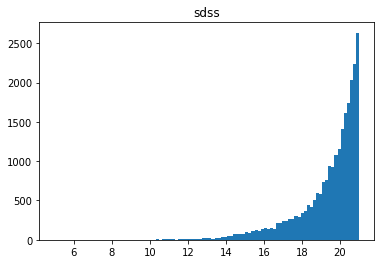

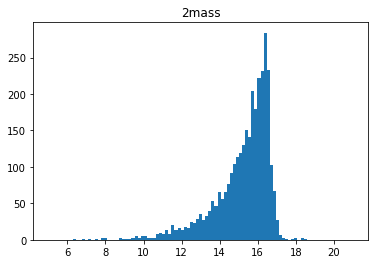

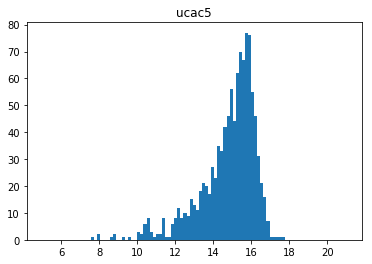

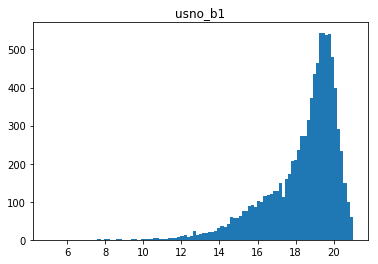

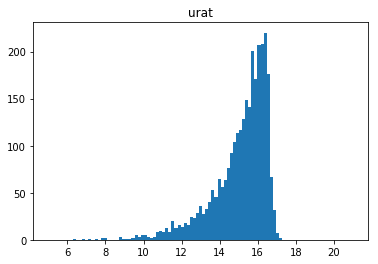

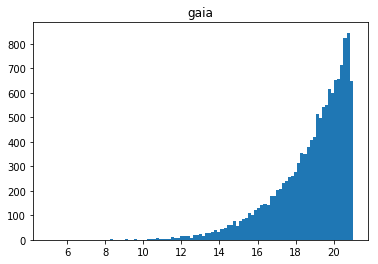

In [110]:
bins = np.linspace(5,21, 100)
for key in nsahost_tables:
    plt.figure()
    plt.hist(nsahost_tables[key][mag_field_names[key]], bins=bins)
    plt.title(key)

The first column gives the matches between the catalogs - the peaks at the left are "real" matchs.

The second column of the plots below are the offset from DES to each of the astrometric sources, for stars with r mags in the 16-17 range (which is a rough area of overlap for all the surveys).  It also gives various statistics for those matches, particularly the *mean* offset between the catalogs (the red dot, relative to the black dot which is a 0-offset)

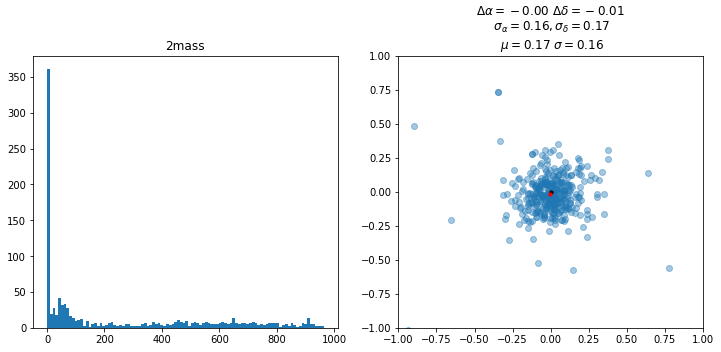

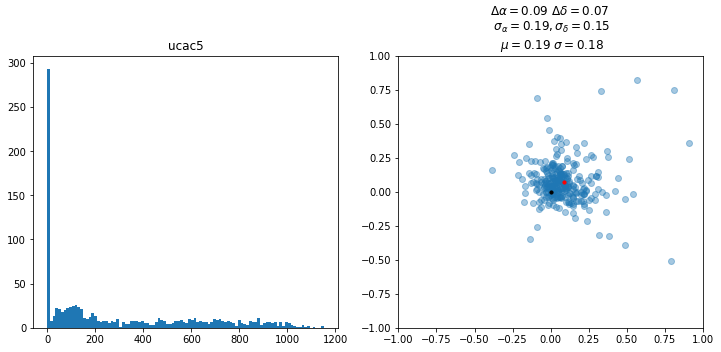

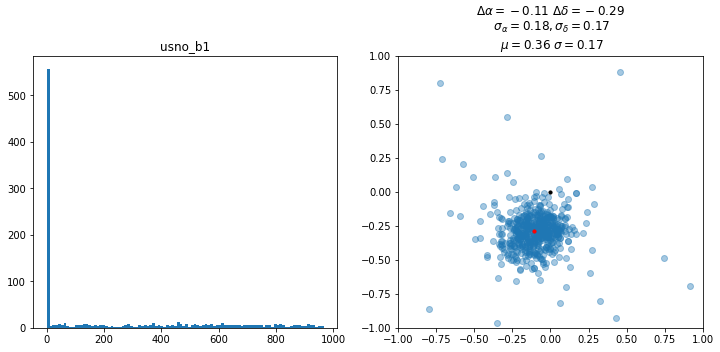

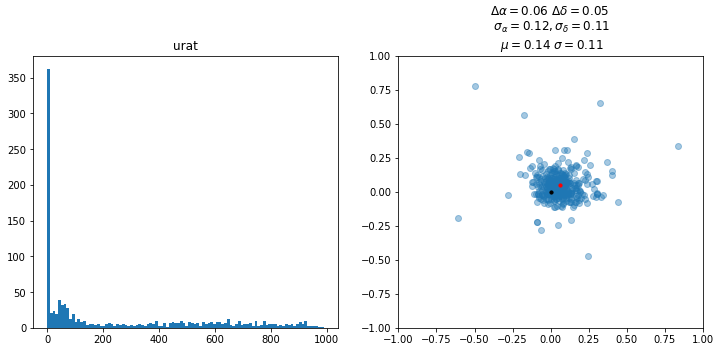

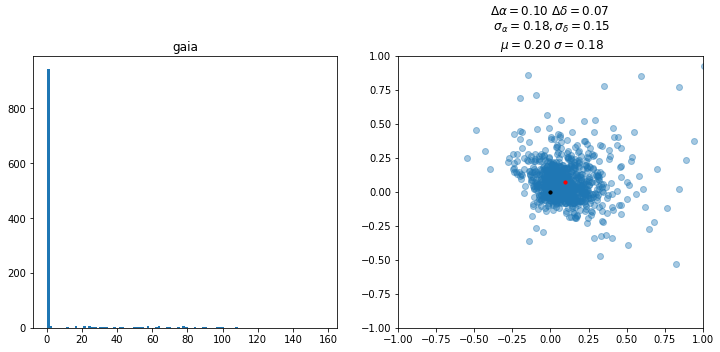

In [111]:
nsc = SkyCoord(nsahost_tables['sdss']['RA'], nsahost_tables['sdss']['DEC'], unit=u.deg)
nmag = nsahost_tables['sdss'][mag_field_names['sdss']]

magrng = (16, 17)
d_matchmag = 1

nsc_msk = nsc[(magrng[0]<nmag)&(nmag<magrng[1])]

for key in nsahost_tables:
    if key == 'sdss':
        continue
    t = nsahost_tables[key]
    sc = SkyCoord(t['ra'], t['dec'], unit=u.deg)
    mag = t[mag_field_names[key]]
    sc_msk = sc[((magrng[0]-d_matchmag)<mag)&(mag<(magrng[1]+d_matchmag))]
    
    idx, d2d, _ = nsc_msk.match_to_catalog_sky(sc_msk)
    dra = nsc_msk.ra - sc_msk[idx].ra
    dracosdec = dra*np.cos(nsc_msk.dec)
    ddec = nsc_msk.dec - sc_msk[idx].dec
    
    sepmsk = d2d < 1.5*u.arcsec
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.hist(d2d.arcsec, bins=100)
    
    ax2.scatter((dracosdec)[sepmsk].arcsec, ddec[sepmsk].arcsec, alpha=.4)
    ax2.scatter([0], [0], c='k', s=10)
    ax2.scatter([np.mean(dra[sepmsk]).arcsec], [np.mean(ddec[sepmsk]).arcsec], c='r', s=10)
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    fmt = (np.mean(dracosdec[sepmsk]).arcsec, np.mean(ddec[sepmsk]).arcsec, 
           np.std(dracosdec[sepmsk]).arcsec, np.std(ddec[sepmsk]).arcsec, 
           np.mean(d2d[sepmsk]).arcsec, np.std(d2d[sepmsk]).arcsec)
    ax2.set_title('$\\Delta \\alpha={:.2f}$ $\\Delta \\delta={:.2f}$ \n $\\sigma_\\alpha={:.2f}, \\sigma_\\delta={:.2f}$ \n $\\mu={:.2f}$ $\\sigma={:.2f}$'.format(*fmt))
    
    ax1.set_title(key)
    

Now we look at the DES host

## DES Host (PGC 2052)

In [112]:
deshost

<Row index=0 masked=True>
SAGA_name NSAID    RA     Dec     PGC  NSA1ID  NGC   UGC   vhelio distance    r       i       z       I       K     K_err   flag  K_abs    r_abs     b    dist_to_group brightest_K_nearby SDSS_FRACGOOD  RA_sub Dec_sub othername vhelio_sub vhelio_err distance_sub dist_2MASS_NSA    u     u_err    A_u     M_u      g     g_err    A_g     M_g    r_sub   r_err    A_r     M_r    i_sub   i_err    A_i     M_i    z_sub   z_err    A_z     M_z      J     J_err    A_J     M_J      H     H_err    A_H     M_H    K_sub  K_err_sub   A_K     M_K   stellar_mass sersic_n MK_compiled des_dr1 decals_dr5 decals_dr6      coord        ID_STR
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           deg,deg             
  str11   int64 float64 float64  int64 int64  int64 int64 float64 float64  float64 float64 float64 float64 float64 float64 int64 float64  float64 float64    float64         float64          float64    float64 float64   str16    float64     int64      float64       float64     float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64  float64  float64 float64    int64     float64    float64   float64  float64    float64        object        str9 
--------- ----- ------- -------- ----- ------ ----- ----- ------- -------- ------- ------- ------- ------- ------- ------- ----- -------- ------- ------- ------------- ------------------ ------------- ------- ------- --------- ---------- ---------- ------------ -------------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- --------- ------- ------- ------------ -------- ----------- ------- ---------- ---------- ---------------- -------
       --    -1 8.56455 -27.8037  2052     -1   150    -1  1583.0  22.9306      --      --      --   10.29   8.506    0.02    48 -23.2961      --  -86.13       7.30434             12.136           0.0      --      --        --         --         --           --             --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --      --        --      --      --           --       --    -23.2961     1.0        0.0        0.0 8.56455,-27.8037 pgc2052

In [113]:
deshost_tables = {}
deshost_tables['desdr1'] = table.Table.read('external_catalogs/des_dr1/{}_des_dr1.fits.gz'.format(deshost['ID_STR']))
deshost_tables['2mass'] = table.Table.read('external_catalogs/astrometric/{}_2mass.tbl'.format(deshost['ID_STR']),
                                           format='ascii')
deshost_tables['ucac5'] = table.Table.read('external_catalogs/astrometric/{}_ucac5.tbl'.format(deshost['ID_STR']),
                                           format='ascii')
deshost_tables['usno_b1'] = table.Table.read('external_catalogs/astrometric/{}_usno_b1.tbl'.format(deshost['ID_STR']),
                                           format='ascii')
deshost_tables['gaia'] = table.Table.read('external_catalogs/astrometric/{}_gaia.ecsv'.format(deshost['ID_STR']),
                                           format='ascii.ecsv')

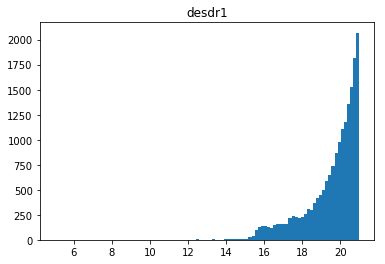

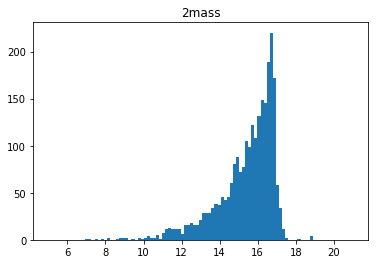

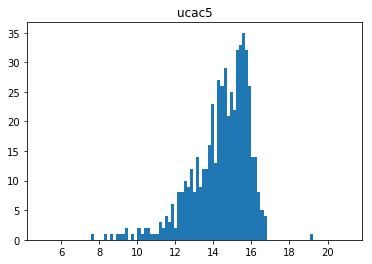

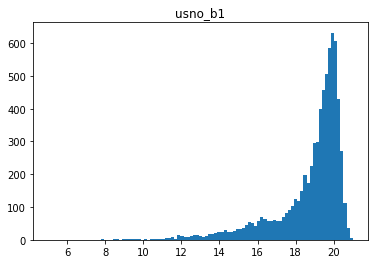

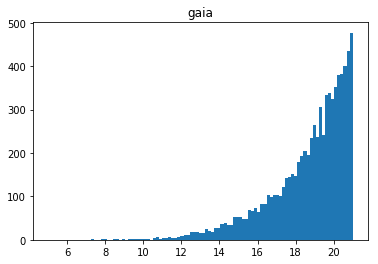

In [114]:
bins = np.linspace(5,21, 100)
for key in deshost_tables:
    plt.figure()
    plt.hist(deshost_tables[key][mag_field_names[key]], bins=bins)
    plt.title(key)

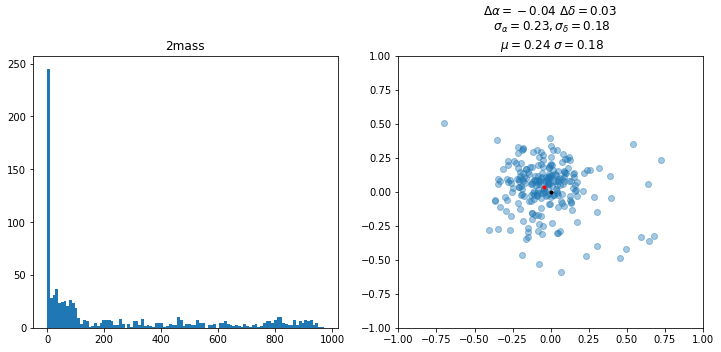

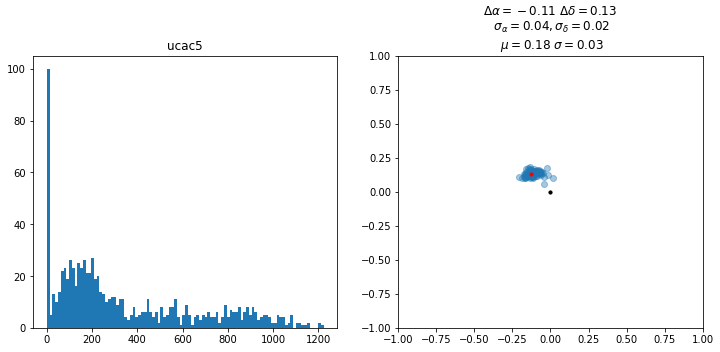

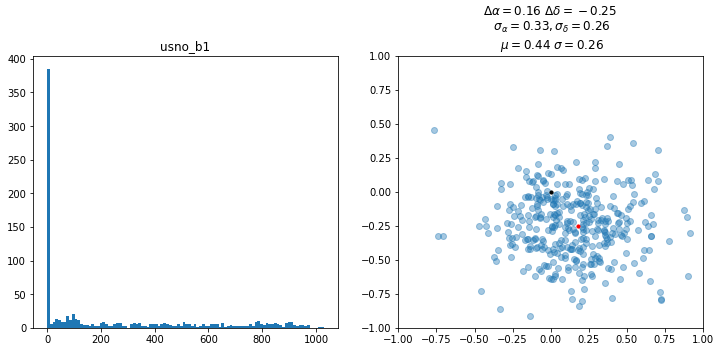

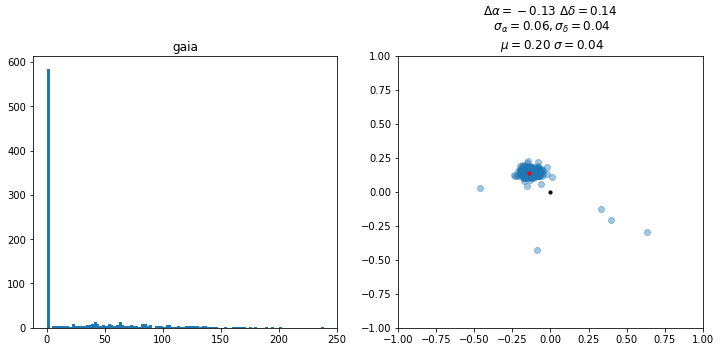

In [115]:
dsc = SkyCoord(deshost_tables['desdr1']['ra'], deshost_tables['desdr1']['dec'], unit=u.deg)
dmag = deshost_tables['desdr1'][mag_field_names['desdr1']]

magrng = (16, 17)
d_matchmag = 1

dsc_msk = dsc[(magrng[0]<dmag)&(dmag<magrng[1])]

for key in deshost_tables:
    if key == 'desdr1':
        continue
    t = deshost_tables[key]
    sc = SkyCoord(t['ra'], t['dec'], unit=u.deg)
    mag = t[mag_field_names[key]]
    sc_msk = sc[((magrng[0]-d_matchmag)<mag)&(mag<(magrng[1]+d_matchmag))]
    
    idx, d2d, _ = dsc_msk.match_to_catalog_sky(sc_msk)
    dra = dsc_msk.ra - sc_msk[idx].ra
    dracosdec = dra*np.cos(dsc_msk.dec)
    ddec = dsc_msk.dec - sc_msk[idx].dec
    
    sepmsk = d2d < 1.5*u.arcsec
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.hist(d2d.arcsec, bins=100)
    
    ax2.scatter((dracosdec)[sepmsk].arcsec, ddec[sepmsk].arcsec, alpha=.4)
    ax2.scatter([0], [0], c='k', s=10)
    ax2.scatter([np.mean(dra[sepmsk]).arcsec], [np.mean(ddec[sepmsk]).arcsec], c='r', s=10)
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    fmt = (np.mean(dracosdec[sepmsk]).arcsec, np.mean(ddec[sepmsk]).arcsec, 
           np.std(dracosdec[sepmsk]).arcsec, np.std(ddec[sepmsk]).arcsec, 
           np.mean(d2d[sepmsk]).arcsec, np.std(d2d[sepmsk]).arcsec)
    ax2.set_title('$\\Delta \\alpha={:.2f}$ $\\Delta \\delta={:.2f}$ \n $\\sigma_\\alpha={:.2f}, \\sigma_\\delta={:.2f}$ \n $\\mu={:.2f}$ $\\sigma={:.2f}$'.format(*fmt))
    
    ax1.set_title(key)
    

The plots above are the same as above - they show the astrometric offsets between mag 16-17 DES stars to their matches in the astrometric sources.

Upshot: Gaia seems to work best by a fairly wide margin... But there is an astrometric offset at the ~tenths of an arcsecond level. Probably this is because 2MASS is the DES astrometric reference frame.  But it seems to be just an offset because the matches are otherwise very good.

## Repeat for other DES hosts 

In [116]:
pgcs_up_jun_aat = (64427, 66318, 66934, 67146, 67663, 67817, 68128, 69521,70094, 71548, 71729, 2052, 2778, 3089, 5619)
des_hosts_up_jun_aat = des_hosts[np.in1d(des_hosts['PGC'], pgcs_up_jun_aat)]
des_hosts_up_jun_aat

<Table masked=True length=15>
SAGA_name NSAID    RA     Dec    ... decals_dr6      coord        ID_STR 
                                 ...                deg,deg              
  str11   int64 float64 float64  ...  float64        object        str9  
--------- ----- ------- -------- ... ---------- ---------------- --------
       --    -1 8.56455 -27.8037 ...        0.0 8.56455,-27.8037  pgc2052
       --    -1 11.8665 -31.4221 ...        0.0 11.8665,-31.4221  pgc2778
       --    -1 13.1765 -31.2058 ...        0.0 13.1765,-31.2058  pgc3089
       --    -1  22.619 -22.6672 ...        0.0  22.619,-22.6672  pgc5619
       --    -1 304.322 -52.7968 ...        0.0 304.322,-52.7968 pgc64427
       --    -1 317.967 -49.2838 ...        0.0 317.967,-49.2838 pgc66318
       --    -1 323.147 -44.0676 ...        0.0 323.147,-44.0676 pgc66934
       --    -1 325.054 -42.5394 ...        0.0 325.054,-42.5394 pgc67146
       --    -1  329.04  -49.522 ...        0.0   329.04,-49.522 pgc67663
       --    -1 330.137 -43.3898 ...        0.0 330.137,-43.3898 pgc67817
       --    -1 332.143 -57.4426 ...        0.0 332.143,-57.4426 pgc68128
       --    -1 340.468 -44.7673 ...        0.0 340.468,-44.7673 pgc69521
       --    -1 344.306 -43.3961 ...        0.0 344.306,-43.3961 pgc70094
       --    -1 352.181 -41.3334 ...        0.0 352.181,-41.3334 pgc71548
       --    -1  353.32 -54.0945 ...        0.0  353.32,-54.0945 pgc71729

In [52]:
for host in des_hosts_up_jun_aat:
    print('On host', host['ID_STR'])
    fn = 'external_catalogs/astrometric/{}_gaia.ecsv'.format(host['ID_STR'])
    if os.path.exists(fn):
        print('File', fn, 'exists, skipping.')
        continue
    gaiajob = Gaia.cone_search_async(host['coord'], radius=1*u.deg)
    gaia_tab = gaiajob.get_data()
    gaia_tab.write(fn, format='ascii.ecsv')

On host pgc2052
File external_catalogs/astrometric/pgc2052_gaia.ecsv exists, skipping.
On host pgc2778


Query finished.
On host pgc3089
Query finished.
On host pgc5619
Query finished.
On host pgc64427
Query finished.
On host pgc66318
Query finished.
On host pgc66934
Query finished.
On host pgc67146
Query finished.
On host pgc67663
Query finished.
On host pgc67817
Query finished.
On host pgc68128
Query finished.
On host pgc69521
Query finished.
On host pgc70094
Query finished.
On host pgc71548
Query finished.
On host pgc71729
Query finished.


In [53]:
des_tables = {}
gaia_tables = {}
for host in des_hosts_up_jun_aat:
    des_tables[host['ID_STR']] = table.Table.read('external_catalogs/des_dr1/{}_des_dr1.fits.gz'.format(host['ID_STR']))
    gaia_tables[host['ID_STR']] = table.Table.read('external_catalogs/astrometric/{}_gaia.ecsv'.format(host['ID_STR']))

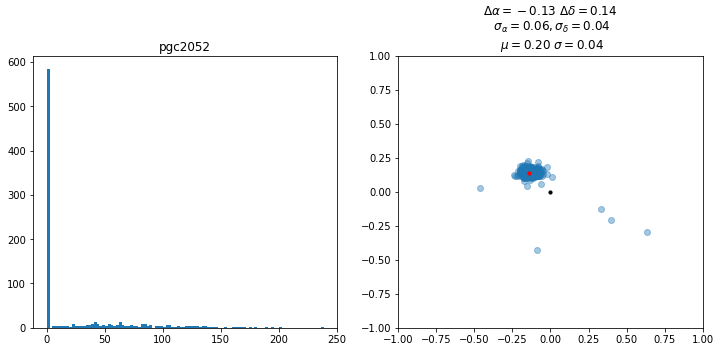

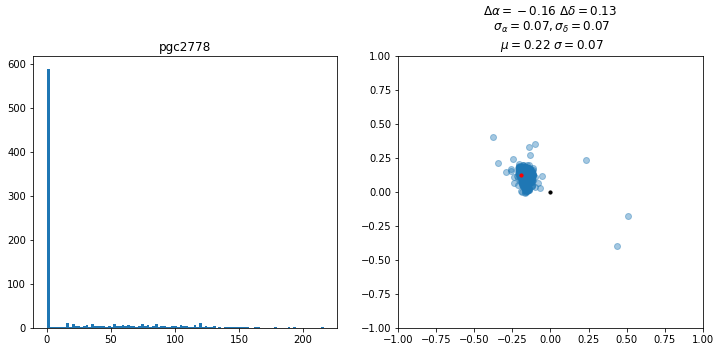

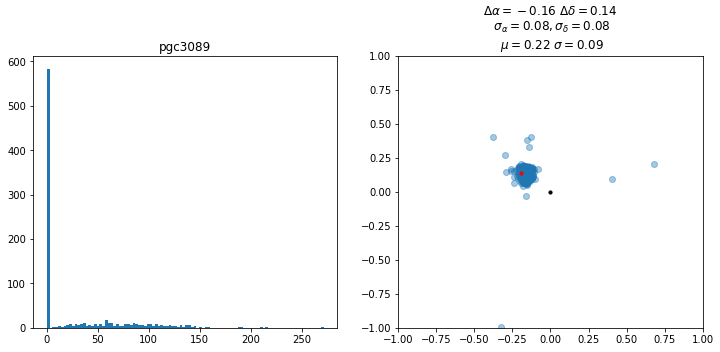

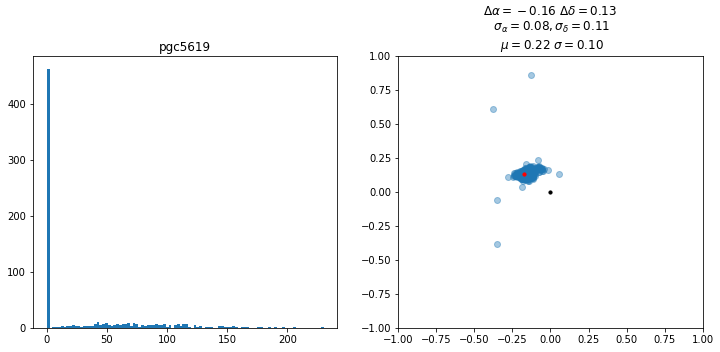

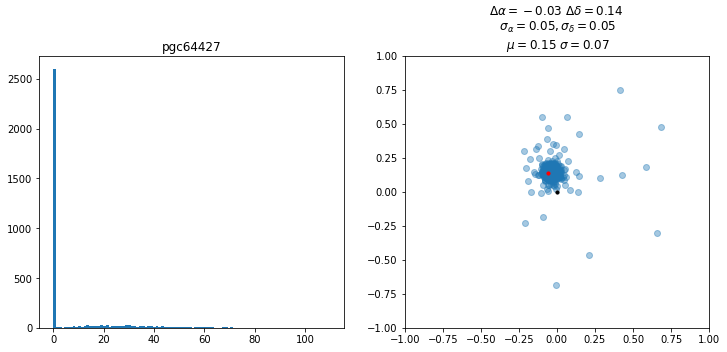

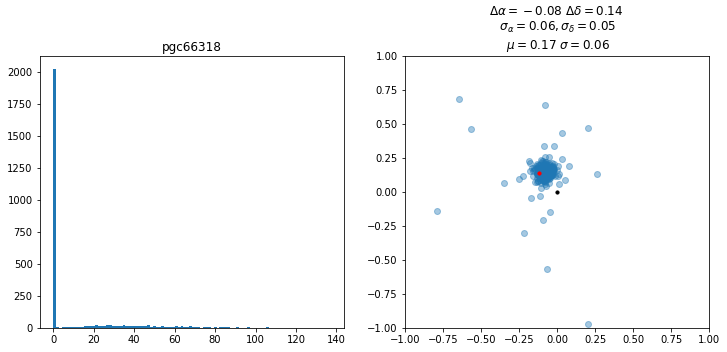

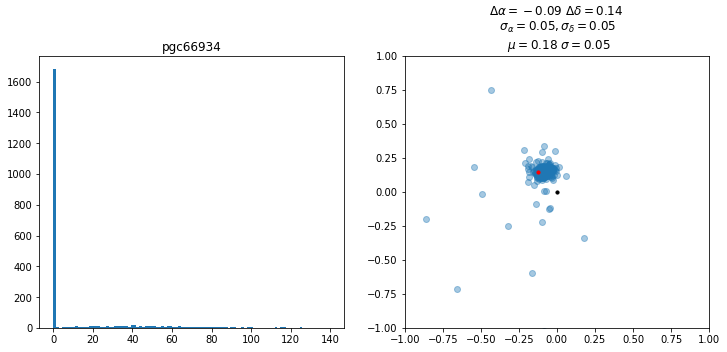

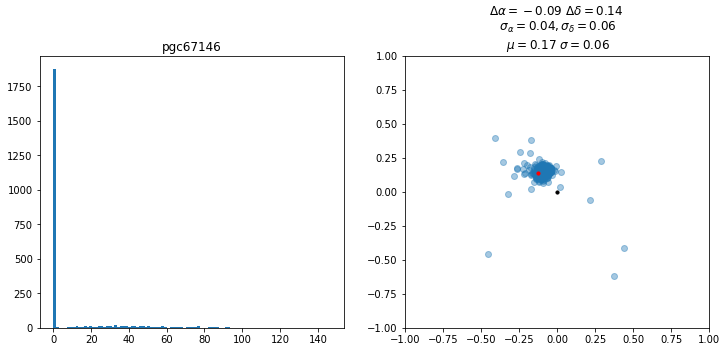

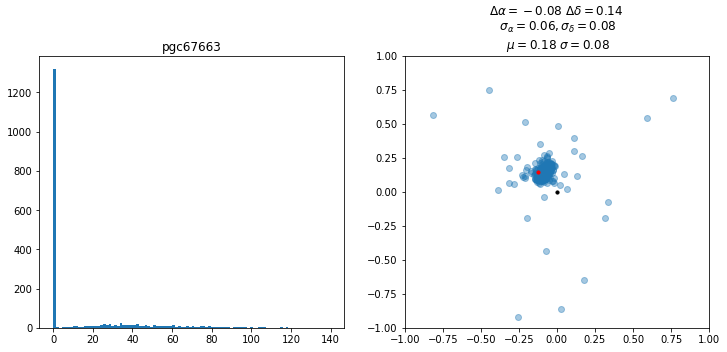

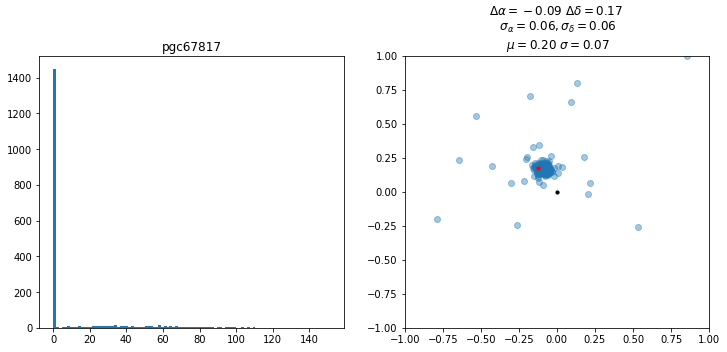

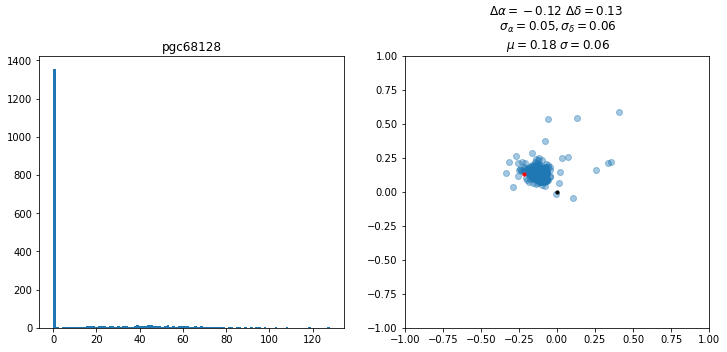

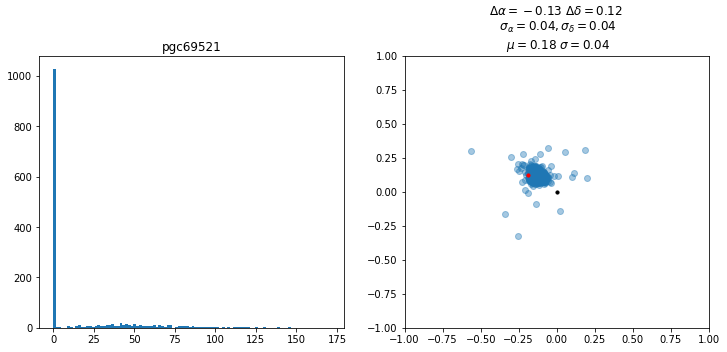

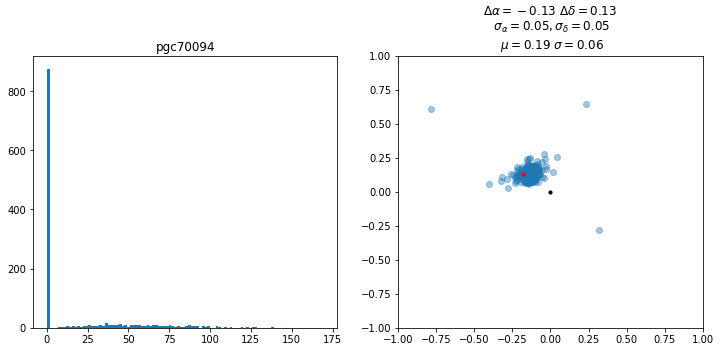

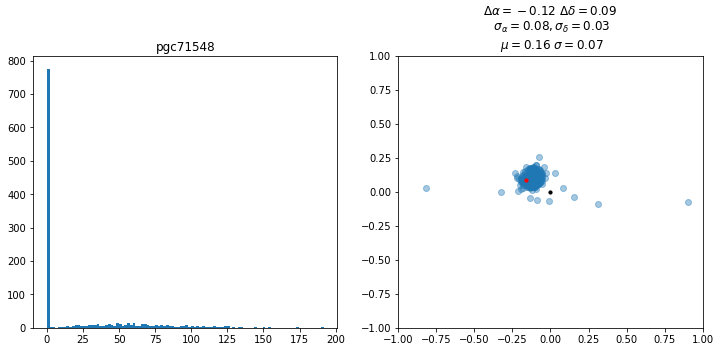

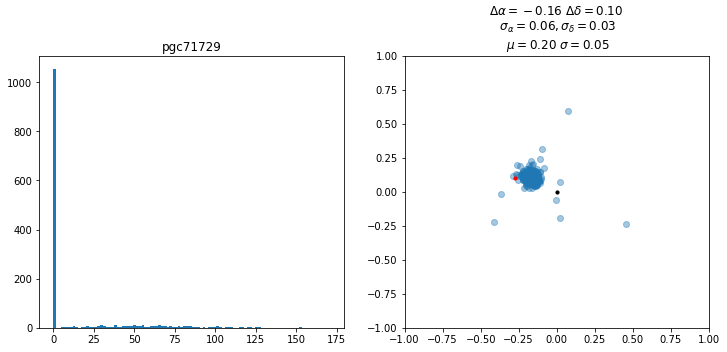

In [54]:
magrng = (16, 17)
d_matchmag = 1

for host in des_hosts_up_jun_aat:
    des_table = des_tables[host['ID_STR']]
    gaia_table = gaia_tables[host['ID_STR']]
    
    dsc = SkyCoord(des_table['ra'], des_table['dec'], unit=u.deg)
    dmag = des_table[mag_field_names['desdr1']]
    dsc_msk = dsc[(magrng[0]<dmag)&(dmag<magrng[1])]
    
    sc = SkyCoord(gaia_table['ra'], gaia_table['dec'], unit=u.deg)
    mag = gaia_table[mag_field_names['gaia']]
    sc_msk = sc[((magrng[0]-d_matchmag)<mag)&(mag<(magrng[1]+d_matchmag))]
    
    idx, d2d, _ = dsc_msk.match_to_catalog_sky(sc_msk)
    dra = dsc_msk.ra - sc_msk[idx].ra
    dracosdec = dra*np.cos(dsc_msk.dec)
    ddec = dsc_msk.dec - sc_msk[idx].dec
    
    sepmsk = d2d < 1.5*u.arcsec
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.hist(d2d.arcsec, bins=100)
    
    ax2.scatter((dracosdec)[sepmsk].arcsec, ddec[sepmsk].arcsec, alpha=.4)
    ax2.scatter([0], [0], c='k', s=10)
    ax2.scatter([np.mean(dra[sepmsk]).arcsec], [np.mean(ddec[sepmsk]).arcsec], c='r', s=10)
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    fmt = (np.mean(dracosdec[sepmsk]).arcsec, np.mean(ddec[sepmsk]).arcsec, 
           np.std(dracosdec[sepmsk]).arcsec, np.std(ddec[sepmsk]).arcsec, 
           np.mean(d2d[sepmsk]).arcsec, np.std(d2d[sepmsk]).arcsec)
    ax2.set_title('$\\Delta \\alpha={:.2f}$ $\\Delta \\delta={:.2f}$ \n $\\sigma_\\alpha={:.2f}, \\sigma_\\delta={:.2f}$ \n $\\mu={:.2f}$ $\\sigma={:.2f}$'.format(*fmt))
    
    ax1.set_title(host['ID_STR'])